# Lung Cancer Detection

## Download Data

In [6]:
!wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/bhmdr45bh2-2.zip

--2021-06-13 10:18:07--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/bhmdr45bh2-2.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.53.115
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.53.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156614682 (149M) [application/octet-stream]
Saving to: ‘bhmdr45bh2-2.zip’

bhmdr45bh2-2.zip    100%[===================>] 149.36M  11.6MB/s    in 15s     

2021-06-13 10:18:23 (10.0 MB/s) - ‘bhmdr45bh2-2.zip’ saved [156614682/156614682]



## Extract Data

In [7]:
!unzip '/content/bhmdr45bh2-2.zip' -d '/tmp'

Archive:  /content/bhmdr45bh2-2.zip
  inflating: /tmp/The IQ-OTHNCCD lung cancer dataset.zip  


In [ ]:
!unzip '/tmp/The IQ-OTHNCCD lung cancer dataset.zip' -d '/tmp'

## Splitting Data

In [9]:
import os

try:
    os.makedirs("/tmp/lung-cancer/training/benign/")
    os.makedirs("/tmp/lung-cancer/testing/benign/")

    os.makedirs("/tmp/lung-cancer/training/malignant/")
    os.makedirs("/tmp/lung-cancer/testing/malignant/")

    os.makedirs("/tmp/lung-cancer/training/normal/")
    os.makedirs("/tmp/lung-cancer/testing/normal/")

except OSError:
    pass

In [10]:
import random
from shutil import copyfile

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    dir_content = random.sample(os.listdir(SOURCE), len(os.listdir(SOURCE)))
    train_size = int(len(dir_content) * SPLIT_SIZE)
    for i, image_name in enumerate(dir_content):
        if os.path.getsize(os.path.join(SOURCE, image_name)) > 0:
            if i < train_size:
                copyfile(os.path.join(SOURCE, image_name), os.path.join(TRAINING, image_name))
            else:
                copyfile(os.path.join(SOURCE, image_name), os.path.join(TESTING, image_name))

BENGIN_SOURCE_DIR = "/tmp/The IQ-OTHNCCD lung cancer dataset/Bengin cases"
TRAINING_BENGIN_DIR = "/tmp/lung-cancer/training/benign/"
TESTING_BENGIN_DIR = "/tmp/lung-cancer/testing/benign/"

MALIGNANT_SOURCE_DIR = "/tmp/The IQ-OTHNCCD lung cancer dataset/Malignant cases"
TRAINING_MALIGNANT_DIR = "/tmp/lung-cancer/training/malignant"
TESTING_MALIGNANT_DIR = "/tmp/lung-cancer/testing/malignant/"

NORMAL_SOURCE_DIR = "/tmp/The IQ-OTHNCCD lung cancer dataset/Normal cases"
TRAINING_NORMAL_DIR = "/tmp/lung-cancer/training/normal/"
TESTING_NORMAL_DIR = "/tmp/lung-cancer/testing/normal/"

split_size = .9
split_data(BENGIN_SOURCE_DIR, TRAINING_BENGIN_DIR, TESTING_BENGIN_DIR, split_size)
split_data(MALIGNANT_SOURCE_DIR, TRAINING_MALIGNANT_DIR, TESTING_MALIGNANT_DIR, split_size)
split_data(NORMAL_SOURCE_DIR, TRAINING_NORMAL_DIR, TESTING_NORMAL_DIR, split_size)

In [11]:
print(len(os.listdir('/tmp/lung-cancer/training/benign/')))
print(len(os.listdir('/tmp/lung-cancer/training/malignant/')))
print(len(os.listdir('/tmp/lung-cancer/training/normal/')))
print()
print(len(os.listdir('/tmp/lung-cancer/testing/benign/')))
print(len(os.listdir('/tmp/lung-cancer/testing/malignant/')))
print(len(os.listdir('/tmp/lung-cancer/testing/normal/')))

108
504
374

12
57
42


# ResNet

## Modeling with Resnet

In [18]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import L1
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

conv_base = ResNet50V2(include_top=False, weights='imagenet',
                       input_shape=(150,150,3))

conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'conv5_block1_3_conv':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

model = Sequential()
model.add(layers.Conv2D(3, (3,3), padding='same',
                        input_shape=(150,150,1)))
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu',
                                kernel_regularizer=L2(0.1)))
model.add(layers.Dense(3, activation='softmax'))

optimizer= Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
             metrics=[keras.metrics.Precision(name='precision'),
                        keras.metrics.Recall(name='recall'),
                        keras.metrics.AUC(name='auc'),
                        keras.metrics.CategoricalAccuracy(name='acc')])                                                     

## Image Augment Resnet

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAINING_DIR = "/tmp/lung-cancer/training/"
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    shear_range=.2,
    zoom_range=.2,
    fill_mode="nearest",
    horizontal_flip=True,
)

train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(150, 150),
    batch_size=10,
    class_mode="categorical",
    color_mode='grayscale',
)

VALIDATION_DIR = "/tmp/lung-cancer/testing/"
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(150, 150),
    batch_size=10,
    class_mode="categorical",
    color_mode='grayscale',
)

Found 986 images belonging to 3 classes.
Found 111 images belonging to 3 classes.


## Training

In [19]:
class myCallback(tf.keras.callbacks.Callback):
  def __init__(self,
               desired_acc=0.5):
    self.desired_acc = desired_acc

  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_acc')>self.desired_acc):
      print(f"\nReached {self.desired_acc} accuracy so cancelling training!")
      self.model.stop_training = True

In [20]:
epochs = 100
callbacks = myCallback(0.98)
history = model.fit(train_generator,
                    epochs=100,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=[callbacks])

Epoch 1/100
99/99 [==============================] - 24s 194ms/step - loss: 12.7010 - precision: 0.7104 - recall: 0.6045 - auc: 0.8284 - acc: 0.6694 - val_loss: 1.2654 - val_precision: 0.8378 - val_recall: 0.8378 - val_auc: 0.9512 - val_acc: 0.8378
Epoch 2/100
99/99 [==============================] - 18s 176ms/step - loss: 0.8554 - precision: 0.8426 - recall: 0.7819 - auc: 0.9301 - acc: 0.8134 - val_loss: 0.8534 - val_precision: 0.7600 - val_recall: 0.6847 - val_auc: 0.8715 - val_acc: 0.7207
Epoch 3/100
99/99 [==============================] - 18s 177ms/step - loss: 0.4948 - precision: 0.8534 - recall: 0.7972 - auc: 0.9527 - acc: 0.8347 - val_loss: 0.4309 - val_precision: 0.8545 - val_recall: 0.8468 - val_auc: 0.9579 - val_acc: 0.8468
Epoch 4/100
99/99 [==============================] - 17s 176ms/step - loss: 0.4586 - precision: 0.8721 - recall: 0.8022 - auc: 0.9542 - acc: 0.8428 - val_loss: 0.3136 - val_precision: 0.8879 - val_recall: 0.8559 - val_auc: 0.9796 - val_acc: 0.8829
Epoch 5

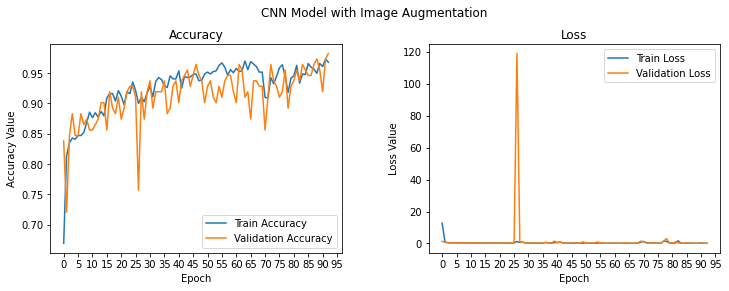

In [25]:
import matplotlib.pyplot as plt
import numpy as np
 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN Model with Image Augmentation', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
 
epoch_list = list(range(93))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")
 
ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## Save Model

In [21]:
model.save('model')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: model/assets


In [22]:
!zip -r /content/ResNet_model.zip /content/model/

  adding: content/model/ (stored 0%)
  adding: content/model/keras_metadata.pb (deflated 96%)
  adding: content/model/assets/ (stored 0%)
  adding: content/model/saved_model.pb (deflated 92%)
  adding: content/model/variables/ (stored 0%)
  adding: content/model/variables/variables.index (deflated 77%)
  adding: content/model/variables/variables.data-00000-of-00001 (deflated 9%)


In [ ]:
from google.colab import files

files.download("/content/ResNet_model.zip")

## Load Model

In [ ]:
from google.colab import files

uploaded_model = files.upload()

In [ ]:
import zipfile

for fn in uploaded_model.keys():
  model_path = '/content/'+ fn
  with zipfile.ZipFile(model_path, 'r') as zip_ref:
    zip_ref.extractall('/')

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model('/content/model')

## Predict

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving gr2.jpg to gr2.jpg
Saving gr1.jpg to gr1.jpg


In [ ]:
file_name = []
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
  file_name.append(fn)

User uploaded file "gr2.jpg" with length 53946 bytes
User uploaded file "gr1.jpg" with length 37306 bytes


In [ ]:
import warnings 
warnings.filterwarnings('ignore')
import tensorflow.keras.preprocessing.image as image
 
def load_image(image_path):
  img = image.load_img(image_path, grayscale=True, target_size=(150, 150))
  img_tensor = image.img_to_array(img) 
  img_tensor = np.expand_dims(img_tensor, axis=0)
  img_tensor /= 255. 
  return img_tensor

for file in file_name:
  image_path = '/content/' + file

  try:
    print(file, 'probability: ', model.predict(load_image(image_path)))
    prediction = model.predict_classes(load_image(image_path))

    if prediction == 0:
      print("It's Benign\n")
    if prediction == 1:
      print("It's Malignant\n")
    if prediction == 2:
      print("It's Normal\n")

  except:
    print("Error!")

gr2.jpg probability:  [[0. 1. 0.]]
It's Malignant

gr1.jpg probability:  [[0. 1. 0.]]
It's Malignant

